In [ ]:
!pip3 install -qq transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 15.9MB/s 
     |████████████████████████████████| 1.1MB 32.9MB/s 
     |████████████████████████████████| 890kB 36.0MB/s 


In [ ]:
!pip3 install --upgrade torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.7.0+cu101)


In [ ]:
import csv
import json

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

In [ ]:
#Encoding:
#small text = 0
#small text- location = 1
#small text- person = 2
#long text = 3
#multiple choice = 4
#date and time = 5
#yes/no = 6
#numeric = 7

d = []

In [ ]:
#open first dataset 
with open('infosys_questions.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
      q = row[0] #question
      q = q.lower()
      #preliminary guess of question type based on question stucture
      if q.split()[0] == "which":
        ans = 4
      elif q.split()[0] == "when":
        ans = 5
      elif q.split()[0] == "who":
        ans = 2
      elif q.split()[0] == "where":
        ans = 1
      elif q.split()[0] == "did" or q.split()[0] == "is":
        ans = 6
      elif q.split()[0] == "how" or q.split()[0] == "explain" or q.split()[0] == "why":
        if q.split()[0] == "how" and q.split()[1] == "many":
          ans = 7
        else:
          ans = 3
      else:
        ans = 0
      
      #finalize question type based on dataset
      out = row[1] #question type
      out = out.lower()
      if out == "essay":
        ans = 3
      elif out == "dropdown" or out == "multiple":
        ans = 4
      elif out == "boolean":
        ans = 6
      elif out == "number":
        ans = 7

      my_dict = {'question': q, 'ans_type': ans}
      d.append(my_dict)

In [ ]:
#open second dataset
with open('dataset.json') as json_file:
    raw = json.load(json_file)

In [ ]:
#restrict number of small text questions using counter 
count = 0 
for each in raw:
  q = each["question"] #question
  q = q.lower()
  q = q.strip('"')
  t = each["type"][0] #question type
  t = t.lower()
  ans = 0
  #preliminary guess of question type based on question stucture
  if q.split()[0] == "which":
    ans = 4
  elif q.split()[0] == "when":
    ans = 5
  elif q.split()[0] == "who":
    ans = 2
  elif q.split()[0] == "where":
    ans = 1
  elif q.split()[0] == "did" or q.split()[0] == "is":
    ans = 6
  elif q.split()[0] == "how" or q.split()[0] == "explain" or q.split()[0] == "why":
    if q.split()[0] == "how" and q.split()[1] == "many":
      ans = 7
    else:
      ans = 3
  else:
    count = count + 1
    ans = 0
  
  #finalize question type based on dataset
  if t == "boolean":
    ans = 6
  if t == "number":
    ans = 7
  if t == "date":
    ans = 5
  if t == "city/town" or t == "city" or t == "country":
    ans = 1

  my_dict = {'question': q, 'ans_type': ans}
  if my_dict['question'] != "n/a": #restrict to valid questions
    if my_dict['ans_type'] != 0 or count < 6500:
      d.append(my_dict)

In [ ]:
#open third dataset
with open('dataset2.json') as json_file:
    raw2 = json.load(json_file)

In [ ]:
for each in raw2:
  q = each["question"]
  if q is not None:
    q = q.lower() #question 
    q = q.strip('"')
    if each["type"]:
      t = each["type"][0] #question type
      t = t.lower()
      ans = 0

      #preliminary guess of question type based on question stucture
      if q.split()[0] == "which":
        ans = 4
      elif q.split()[0] == "when":
        ans = 5
      elif q.split()[0] == "who":
        ans = 2
      elif q.split()[0] == "where":
        ans = 1
      elif q.split()[0] == "did" or q.split()[0] == "is":
        ans = 6
      elif q.split()[0] == "how" or q.split()[0] == "explain" or q.split()[0] == "why":
        if q.split()[0] == "how" and q.split()[1] == "many":
          ans = 7
        else:
          ans = 3
      else:
        ans = 0
      
      #finalize question type based on dataset
      if t == "boolean":
        ans = 6
      if t == "number":
        ans = 7
      if t == "date":
        ans = 5
      if t[4:] == "city/town" or t[4:] == "city" or t[4:] == "country":
        ans = 1
      if t[4:] == "person":
        ans = 2

      my_dict = {'question': q, 'ans_type': ans}
      if my_dict['question'] != "n/a" and my_dict['ans_type'] != 0:
        d.append(my_dict)

In [ ]:
#open fourth dataset
with open('questions.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    count = 0 #restrict number of small text questions using counter 
    for row in readCSV:
      if count > 18000:
        break
      q = row[0] #question
      q = q.lower()
      #preliminary guess of question type based on question stucture
      if count != 0 and len(q) != 0:
        if q.split()[0] == "which":
          ans = 4
        elif q.split()[0] == "when":
          ans = 5
        elif q.split()[0] == "who":
          ans = 2
        elif q.split()[0] == "where":
          ans = 1
        elif q.split()[0] == "did" or q.split()[0] == "is":
          ans = 6
        elif q.split()[0] == "how" or q.split()[0] == "explain" or q.split()[0] == "why":
          if q.split()[0] == "how" and q.split()[1] == "many":
            ans = 7
          elif q.split()[0] == "how" and q.split()[1] == "much":
            ans = 7
          else:
            ans = 3
        else:
          ans = 0

        my_dict = {'question': q, 'ans_type': ans}
        if ans != 0:
          d.append(my_dict)
      count = count + 1

In [ ]:
#convert list to dataframe
df = pd.DataFrame(data=d)
class_names = ['small text', 'small text- location','small text- person', 'long text', 'multiple choice', 'date and time', 'yes/no', 'numeric']
#plot distribution
ax = sns.countplot(df.ans_type)
plt.xlabel('answer types')
ax.set_xticklabels(class_names);

In [ ]:
#loading 'cased' version of bert model
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
#determine max length of questions to add to BERT parameters
token_lens = []

for txt in df.question:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))

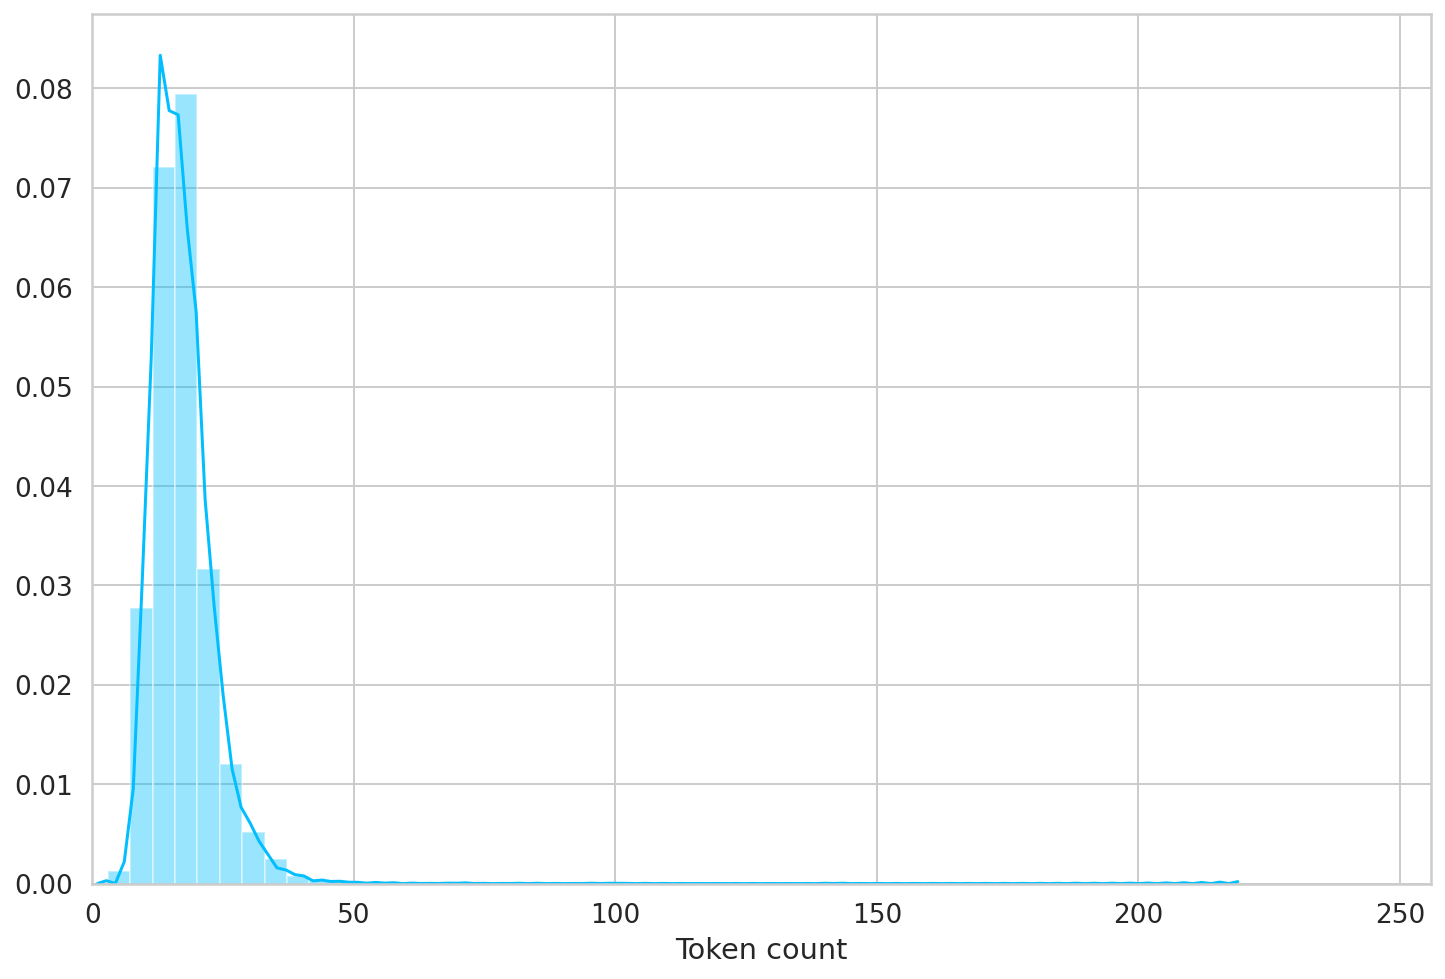

In [ ]:
#graph token length distributions
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 75

In [ ]:
#create a pytorch dataset

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    
    #use tokenizer to encode text
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
#split dataset into training, validation, and testing
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((33944, 2), (1886, 2), (1886, 2))

In [ ]:
#download training and testing datasets 
from google.colab import files

df_train.to_csv('training_set.csv')
df_val.to_csv('validation_set.csv')
df_test.to_csv('testing_set.csv')

files.download('training_set.csv')
files.download('validation_set.csv')
files.download('testing_set.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#create data loaders to format data to train and test model

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.question.to_numpy(),
    targets=df.ans_type.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16
#load training, validation, testing sets
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
#download bert model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
#create a classifer using the bert model

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
#creates an instance and move to GPU
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
#use the AdamW optimizer, provided by Hugging Face, to correct weight decay
#use a linear scheduler

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
#helpfer function to train model for one epoch
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    #encode
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    #output from model
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    #eval output
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#helpfer function to evaluate model on data loader
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      #encode
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      #output from model
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      #eval output
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
#using helper functions above, this training loops trains the model 
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  #train single epoch
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')
 
  #evaluate on testing
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  
  #keep track of accuracies and losses
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.33814795972897016 accuracy 0.9044013669573415
Val   loss 0.2921760574109473 accuracy 0.9151643690349948

Epoch 2/10
----------
Train loss 0.1967243251899208 accuracy 0.9418159321234976
Val   loss 0.26635558679660437 accuracy 0.9220572640509015

Epoch 3/10
----------
Train loss 0.13853550182965857 accuracy 0.955691727551261
Val   loss 0.28172518434180577 accuracy 0.9257688229056205

Epoch 4/10
----------
Train loss 0.10590091410098934 accuracy 0.9660617487626679
Val   loss 0.31383833872357586 accuracy 0.9262990455991518

Epoch 5/10
----------
Train loss 0.08834774043025836 accuracy 0.9721600282818761
Val   loss 0.3896075146351951 accuracy 0.923117709437964

Epoch 6/10
----------
Train loss 0.07375995121289722 accuracy 0.9759014847984917
Val   loss 0.4060357770828532 accuracy 0.9167550371155886

Epoch 7/10
----------
Train loss 0.06626028926185272 accuracy 0.9779047843506953
Val   loss 0.4411722975865675 accuracy 0.9167550371155886

Epoch 8/10
---------

In [ ]:
#plot the training and testing accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
#evaulate to determine testing accuracy
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9289501590668081

In [ ]:
#helper function to get predictions from the model
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      #encode
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      #output from model
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      #eval output
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
#get prediction values of testing data
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
#classification report
print(classification_report(y_test, y_pred, target_names=class_names))

                      precision    recall  f1-score   support

          small text       0.82      0.82      0.82       241
small text- location       0.84      0.80      0.82       166
  small text- person       0.88      0.87      0.88       262
           long text       1.00      0.99      0.99       281
     multiple choice       0.95      0.96      0.95       313
       date and time       0.96      0.96      0.96       166
              yes/no       1.00      1.00      1.00       291
             numeric       0.95      0.98      0.96       166

            accuracy                           0.93      1886
           macro avg       0.92      0.92      0.92      1886
        weighted avg       0.93      0.93      0.93      1886



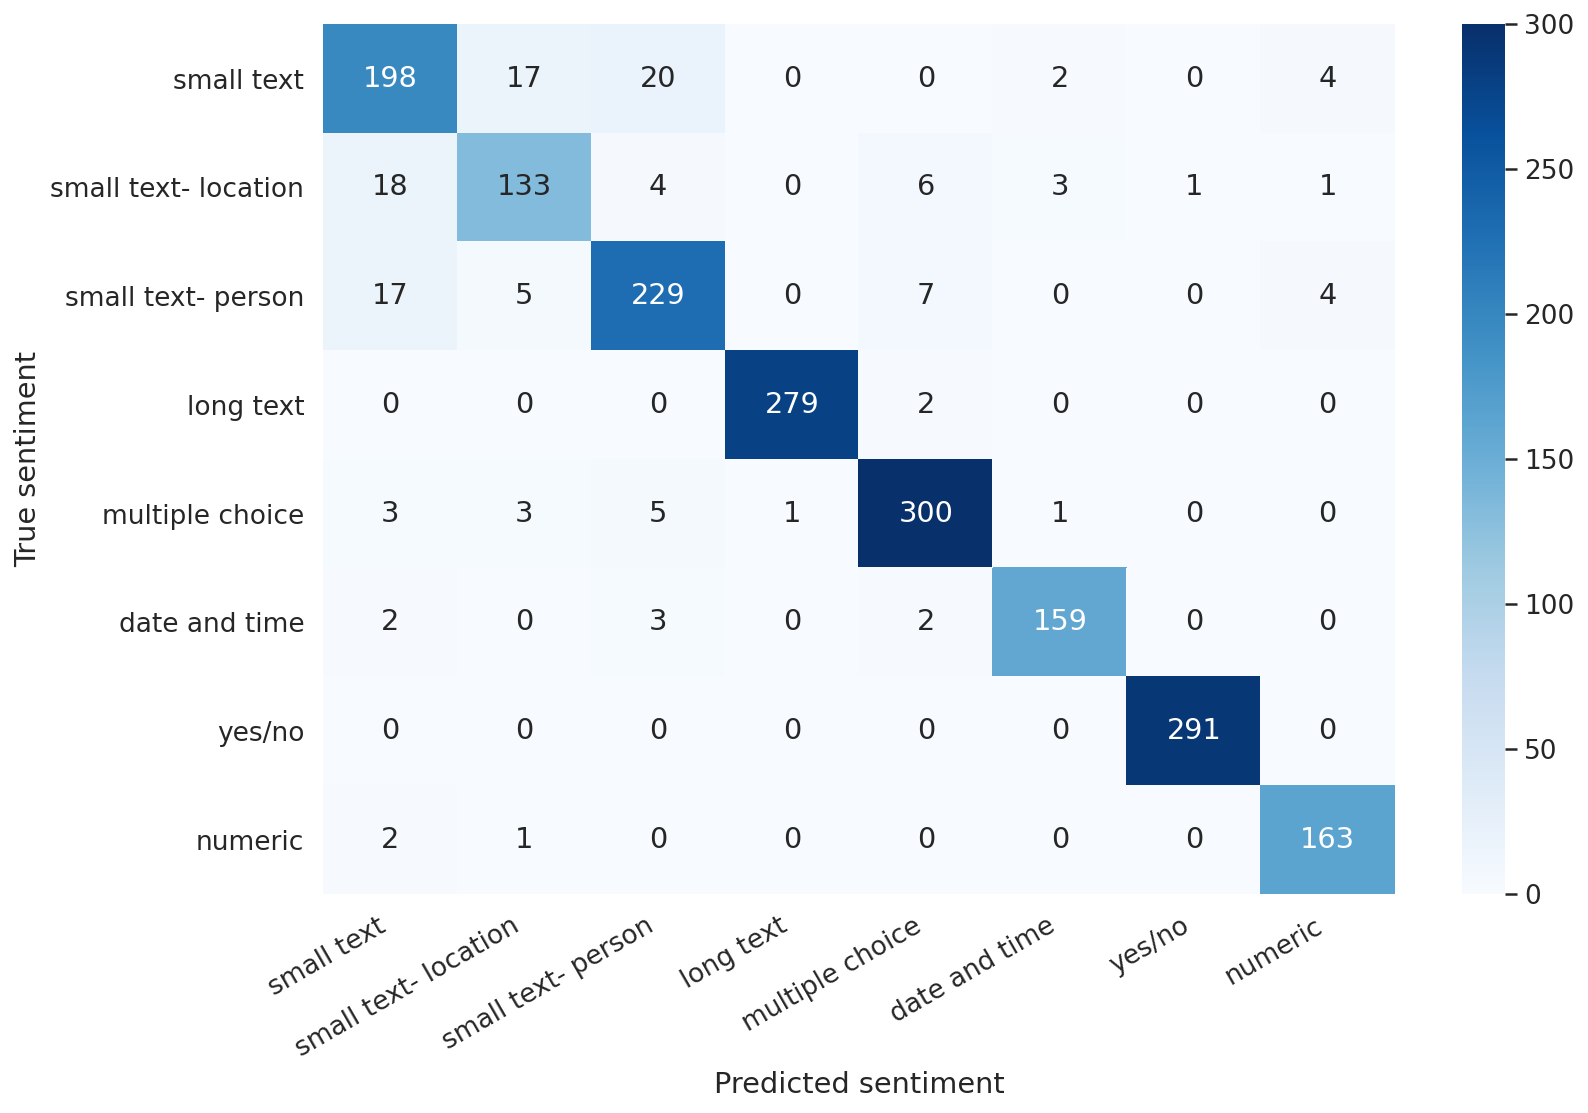

In [ ]:
#helper function to show confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)